# Modelling

En esta sección veremos como implementar modelos de clasificación a nuestros datos que han sido previamente preparados.

Apartados a tratar:
- Iteración de modelos de clasificación sobre dataset desbalanceado.
- Iteración de modelos de clasificación sobre dataset balanceado(SMOTE).
- Analizar e interpretar mejores modelos individualmente (SMOTE).
- Iteración sobre parámetros con GridsearchCV.
- Curva de validación

**Cargamos path**

In [1]:
import os
myfile = open("path.txt",mode="r")

datapath,repopath = myfile.readlines()
datapath = datapath.strip("\n")
datapath,repopath

('D:\\', 'd:\\GIT\\TFM')

**Creamos folders donde vamos a guardar la información de los modelos**

In [2]:
path = os.getcwd()
if path.endswith('TFM') == True:
    !mkdir smote_reports
    !mkdir gsearchcv
    !mkdir model
else:
    print("Ensure that you are in the /TFM folder")

Ya existe el subdirectorio o el archivo smote_reports.
Ya existe el subdirectorio o el archivo gsearchcv.
Ya existe el subdirectorio o el archivo model.


**Importamos librerías**

In [3]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import StandardScaler,\
                                OneHotEncoder,\
                                LabelEncoder,\
                                LabelBinarizer
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.compose import ColumnTransformer

from sklearn.metrics import recall_score,\
                            f1_score,\
                            precision_score,\
                            roc_curve,\
                            roc_auc_score,\
                            accuracy_score,\
                            confusion_matrix,\
                            classification_report
                        
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import LinearSVC


from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split,\
                                    cross_validate,\
                                    learning_curve,\
                                    cross_val_score,\
                                    GridSearchCV,RepeatedKFold,\
                                    validation_curve
                    
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import modules
import joblib

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

**Carga de datos**

In [4]:
def get_data(datapath):
    import random
    p = 0.02 # 1% of the lines
    # keep the header, then take only 1% of lines
    # if random from [0,1] interval is greater than 0.01 the row will be skipped
    df = pd.read_csv(datapath + 'df_imbalanced.csv',index_col=0,skiprows=lambda i: i>0 and random.random() > p,delimiter=',',encoding='UTF-8-SIG')
    return df

In [5]:
df_imbalanced = get_data(datapath)

In [6]:
print('Before Upsampling:')
df_imbalanced['Accident_Severity'].value_counts(normalize=True).reset_index()

Before Upsampling:


,index,Accident_Severity
0,2,0.794576
1,1,0.177638
2,0,0.027786


Como podemos ver, el conjunto de datos está desequilibrado.  Esto es un problema  porque las clases minoritarias reportarán la peor puntuación.  Así que vamos a probar con métricas como la curva au_roc y f1_score, para comprobar qué tan bueno o malo es nuestro modelo antes de aplicar técnicas de Oversampling.

Ordenamos las columnas y comprobamos los datos

In [7]:
df_imbalanced = df_imbalanced[['Accident_Severity',
                               'Vehicle_Type', 
                               'Sex_of_Driver', 
                               'Age_Band_of_Driver',
                               'Engine_Capacity_(CC)', 
                               'Age_of_Vehicle',
                               'Day_of_Week', 
                               'Speed_limit', 
                               'Daytime',
                               'Weather_Conditions_2',
                               'Light_Conditions_2']]

In [8]:
df_imbalanced.head(3)

,Accident_Severity,Vehicle_Type,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Age_of_Vehicle,Day_of_Week,Speed_limit,Daytime,Weather_Conditions_2,Light_Conditions_2
30,2,8,1,4,2.868056,0.477121,4,1.477121,4,1,1
42,1,2,1,4,3.112605,0.301030,0,1.477121,2,1,1
122,2,8,1,4,2.875061,0.000000,5,1.477121,4,1,1


In [9]:
df_imbalanced.shape

(108293, 11)

Nuestro target va a ser : **Accident_Severity**.

El resto de columnas van a ser las **features**.

### *Iteración de modelos de clasificación sobre dataset desbalanceado*

Primero de todo vamos a crear un cross-validation_score con varios modelos de clasificación para saber qué modelos son los que funcionan mejor con los parámetros por defecto.

LogReg| Mean=0.295781 STD=0.000854
SVC_linear| Mean=0.295781 STD=0.000854
DecTree| Mean=0.391386 STD=0.007368
KNN| Mean=0.367735 STD=0.005230
LinDisc| Mean=0.295781 STD=0.000854
BGG| Mean=0.407369 STD=0.010500
rf| Mean=0.400516 STD=0.008321


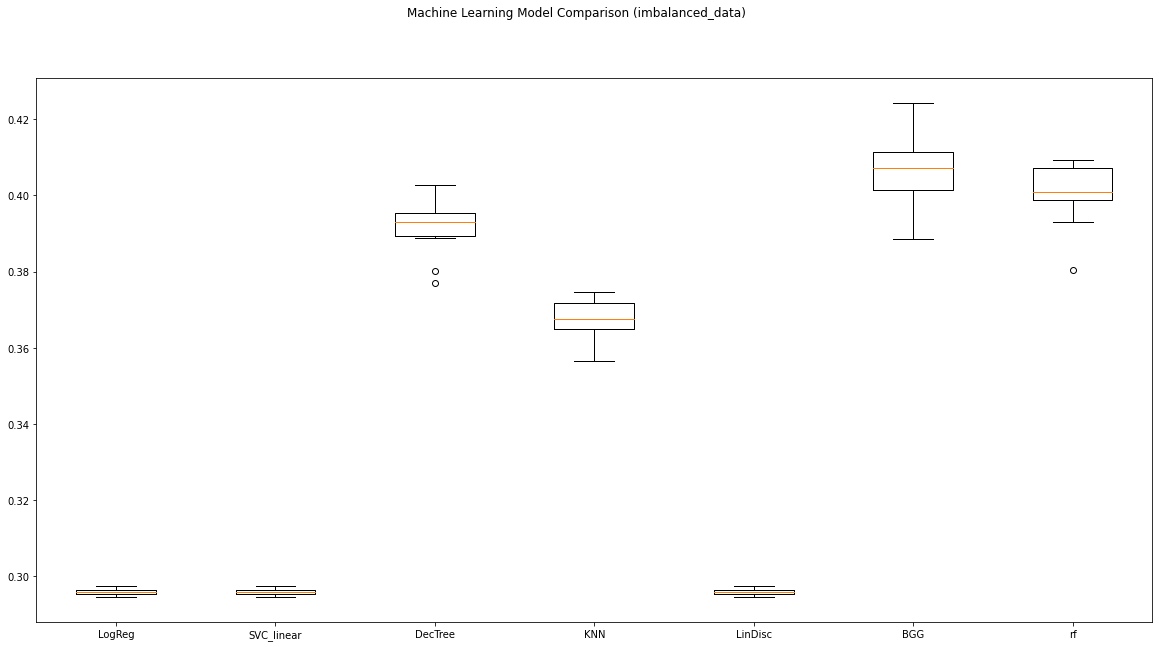

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

from sklearn import model_selection

#read in the data
data_to_use = df_imbalanced   #data
values = data_to_use.values
Y_1 = values[:,0]             #target
X_1 = values[:,1:]            #features

random_seed = 12

outcome = []
model_names = []

models = [
    ('LogReg', LogisticRegression()), 
    ('SVC_linear', LinearSVC()), 
    ('DecTree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('LinDisc', LinearDiscriminantAnalysis()),
    ('BGG', BaggingClassifier()),
    ('rf', RandomForestClassifier())
]


for model_name, model in models:              
    k_fold_validation = model_selection.KFold(n_splits=10, random_state=random_seed,shuffle=True)
    results = model_selection.cross_val_score(model, X_1, Y_1, cv=k_fold_validation, scoring='f1_macro',n_jobs = -1)
    outcome.append(results)
    model_names.append(model_name)
    output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
    print(output_message)

fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison (imbalanced_data)')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show()

Aunque ningún modelo nos está dando un valor más alto  de 0.5 en f1_score, si que destacamos 4 modemos como los más interesantes para probar con ellos.
KNN, DecTree, BGG, Rf.

### *Iteración de modelos de clasificación sobre dataset balanceado (SMOTE)*

#### ***SMOTE OVERSAMPLING***

Nuestras últimas métricas con datos desequilibrados fueron malas, por lo que probaremos con la técnica Oversampling: en nuestro caso usaremos Oversampling en lugar de Undersampling, ambos tienen sus pros y sus contras, pero con Oversample no perderemos datos.


<img src="https://i0.wp.com/dataaspirant.com/wp-content/uploads/2020/08/10-oversampling.png?resize=768%2C407&ssl=1" alt="image info" width="500" />

<img src="https://i1.wp.com/dataaspirant.com/wp-content/uploads/2020/08/17-undersampling.png?resize=768%2C399&ssl=1" alt="image info" width="500" />

[Handling Imbalanced data with python](https://dataaspirant.com/handle-imbalanced-data-machine-learning/#t-1596963627856)

*Oversampling sobre X, y*

In [18]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=12)

In [19]:
X_k, y_k = modules.target_features(df_imbalanced)
X_res, y_res = oversample.fit_resample(X_k, y_k)

# view synthetic sample class distribution
print('\nAfter Upsampling with SMOTE:'), print(pd.Series(y_res).value_counts())


After Upsampling with SMOTE:
0    86792
1    86792
2    86792
Name: Accident_Severity, dtype: int64


(None, None)

Como vemos ya tenemos el dataset balanceado, ya podemos volver a probar los modelos anteriores.

LogReg| Mean=0.453294 STD=0.002820
SVM| Mean=0.417583 STD=0.015515
DecTree| Mean=0.771797 STD=0.002141
KNN| Mean=0.744427 STD=0.002306
LinDisc| Mean=0.446255 STD=0.002705
BGG| Mean=0.811545 STD=0.002218
rf| Mean=0.856399 STD=0.002237


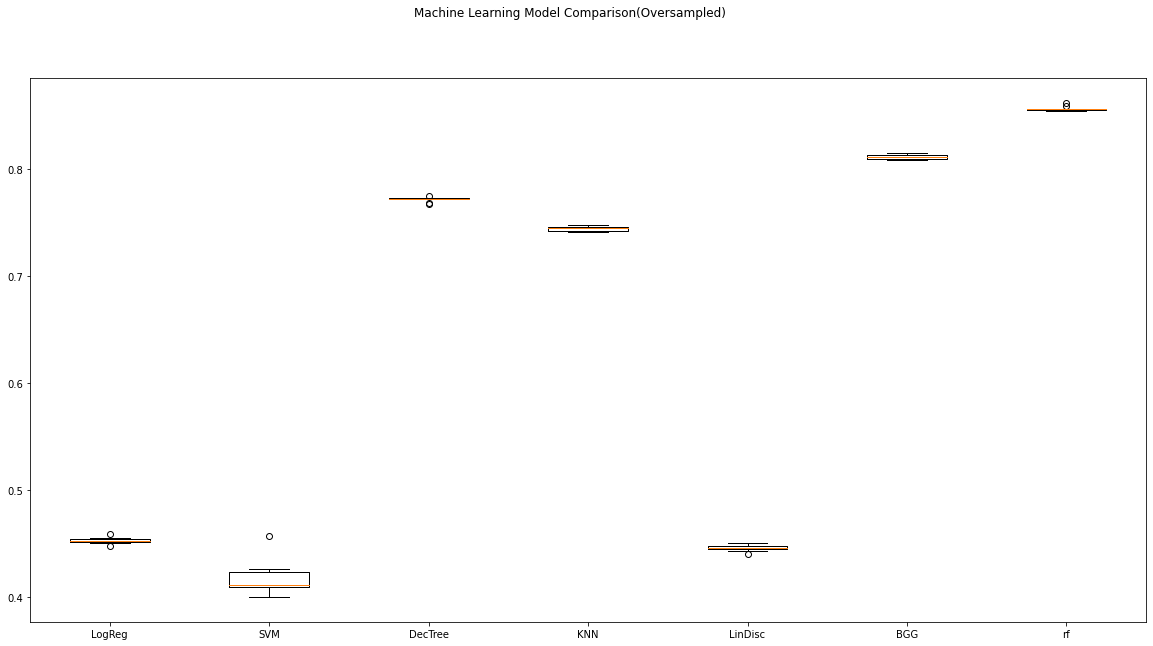

In [20]:
#X,y =  modules.target_features(df_smote)
#oversample = SMOTE()
#X_res, y_res = oversample.fit_resample(X, y)

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


#read in the data
#data_to_use = df_imbalanced
#values = data_to_use.values

Y = y_res.values
X = X_res.values

random_seed = 12

outcome = []
model_names = []

models = [
    ('LogReg', LogisticRegression()), 
    ('SVM', LinearSVC()), 
    ('DecTree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('LinDisc', LinearDiscriminantAnalysis()),
    ('BGG', BaggingClassifier()),
    ('rf', RandomForestClassifier())
]


for model_name, model in models:
    k_fold_validation = model_selection.KFold(n_splits=10, random_state=random_seed,shuffle=True)
    results = model_selection.cross_val_score(model, X, Y, cv=k_fold_validation, scoring='f1_macro',n_jobs = -1)
    outcome.append(results)
    model_names.append(model_name)
    output_message = "%s| Mean=%f STD=%f" % (model_name, results.mean(), results.std())
    print(output_message)
    

fig = plt.figure()
fig.suptitle('Machine Learning Model Comparison(Oversampled)')
ax = fig.add_subplot(111)
plt.boxplot(outcome)
ax.set_xticklabels(model_names)
plt.show()

Podemos ver que los modelos más descatados son los mismos que anteriormente.
Aunque hemos ganado en puntuación en cada uno de ellos, siendo los modelos con más puntuación RandomForestClassifier, y BaggingClassifier.

Definimos las funciones para evaluar los modelos.

In [36]:
#This functions allow us to make predictions using different models.
#folder selection
    #folder=1 for imb_reports
    #folder=2 for bal_reports
    #folder=3 for smote_reports

def fit_pred_mod(select_model):
  #model selection 
    from imblearn.over_sampling import SMOTE
    if select_model == 1:
        model = LogisticRegression()
    elif select_model == 2:
        model = DecisionTreeClassifier()
    elif select_model == 3:
        model = RandomForestClassifier(n_jobs = -1, criterion='entropy', class_weight='balanced')
    elif select_model == 4:
        model = BaggingClassifier(n_jobs = -1)
    elif select_model == 5:
        model = LinearSVC()
    elif select_model == 6:
        model = KNeighborsClassifier(n_jobs = -1)
        
    folder = 'smote_reports'
    
    numeric_features = num
    categorical_features = cat
    #Handling categorical and numerical data with Pipelines
    numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),('pca', PCA())])
    #('imputer', SimpleImputer(strategy='median')),
    #categorical_transformer = LabelEncoder()
    categorical_transformer = Pipeline(steps=[
    
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    #('ohe', OneHotEncoder(handle_unknown='ignore'))])
    
    #categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    #categorical_transformer  = StandardScaler()
    preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),])
        
    clf = Pipeline(steps=[('preprocessor', preprocessor),
    ('classifier', model)])
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    
   
    #clf['preprocessor'].transformers_[1][1]['ohe'].get_feature_names(categorical_features)
    #print(clf["preprocessor"].transformers_[1][1]['scaler'].get_feature_names(numeric_features))
    
    
## Taking the feature names for the feature importance plot
    
    BASE_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    feature_collection = FeatureUnion([('BASE_pipeline', BASE_pipeline)])

    pipeline_collection = Pipeline([('feats', feature_collection),('clf',model)])

    
    
    categorical_features_final = dict(pipeline_collection.named_steps['feats']\
                                        .transformer_list)['BASE_pipeline'].named_steps['preprocessor']\
                                        .transformers_[1][1]\
                                        .named_steps['ohe']\
                                        .get_feature_names(categorical_features)
    
    numerical_features = [col for col in X_train.columns if X_train[col].dtype.name == "float64"]
    categorical_features_final = categorical_features_final.tolist()
    final_features_list = numerical_features + categorical_features_final
    

    eval_score(X_train, X_test, y_train, y_test, clf, yhat,select_model,folder,final_features_list)
    

    return

In [37]:
def eval_score(X_train, X_test, y_train, y_test, classifier,yhat,select_model,folder,final_features_list):
    #  classifier.fit(X_train, y_train)
#    preds = classifier.predict(X_test)
#    probs = classifier.predict_proba(X_test)
    
    if select_model == 1:
        modelts = 'LogisticRegression' # no feature importance
    elif select_model == 2:
        modelts = 'DecisionTreeClassifier'
    elif select_model == 3:
        modelts = 'RandomForestClassifier'
    elif select_model == 4:
        modelts = 'BaggingClassifier' # no feature importance
    elif select_model == 5:
        modelts = 'LinearSVC' # no feature importance
    elif select_model == 6:
        modelts = 'KNeighborsClassifier' # no feature importance
    
    
    with open("model/import_features_{}.txt".format(modelts), "w") as output:
        output.write(str(final_features_list))
    
    joblib.dump(classifier, 'model/{}_model.pkl'.format(modelts))
    print("{}".format(modelts))
    n_class = 3
    print("model score: %.3f" % classifier.score(X_test, y_test))
    cr = classification_report(y_test, yhat)
    print(cr)
    
    f = open(folder+'/report_'+modelts+'.txt', 'w')
    f.write('Classification Report {}\n\n{}'.format(modelts ,cr))
    f.close()
    
  
    fig1,ax = plt.subplots(1,2,figsize=(15,5.5))
    fig1.tight_layout()
    plt.subplots_adjust(top=0.85)
    #plt.subplots_adjust(wspace=1000, hspace=1000)
    
    if select_model in [1,2,3,4,6,7]:
        # roc curve for classes
        fpr = {}
        tpr = {}
        thresh ={}
        probs = classifier.predict_proba(X_test)
        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_test, probs[:,i], pos_label=i)
        #plotting Roc Curve     
        plt.subplot(121)
        #plt.subplots_adjust(wspace=10, hspace=10)
        plt.plot(fpr[0], tpr[0], linestyle='--',color='red', label='Fatal')
        plt.plot(fpr[1], tpr[1], linestyle='--',color='orange', label='Serious')
        plt.plot(fpr[2], tpr[2], linestyle='--',color='green', label='Slight')
        plt.title('Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
        #plt.savefig(folder+'/'+ modelts+'Multiclass ROC',dpi=300);
        roc_auc_score(y_test, probs,multi_class='ovo', average='weighted')
    
    #matrix confusion
    matrix = confusion_matrix(y_test, yhat)
    dataframe = pd.DataFrame(matrix, index=['Fatal', 'Serious', 'Slight'], 
                            columns=['Fatal', 'Serious', 'Slight'])
    
    # create matrixconfusion heatmap
    plt.subplot(122)

    sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
    plt.show()
    fig1.savefig(folder+'/' + modelts +' Multiclass ROC Curve - Confusion Matrix');
    
    
        
    #features importance
    if select_model in [2,3]:
        fig2,ax = plt.subplots()
        feat_importances = pd.Series(classifier.steps[1][1].feature_importances_, index=final_features_list)

        feat_importances.nlargest(n=20).sort_values(ascending=True).plot(kind='barh',color='Orange',width=0.3, figsize=(15,7))
        plt.xlabel('Relative Feature Importance with {}'.format(modelts));
        plt.show();
        
        fig2.savefig(folder+'/'+ modelts+'Feat_import',dpi=50);

    return

**Oversampling y train-test-split**

Pasos antes de evaluar cada modelo:
1. Dividimos en features y target.
2. Guardamos variables categorias y numéricas en listas.
3. Oversampling, devolvemos (X,y) balanceadas.
4. Dividimos en Train test split.

In [51]:
oversample = SMOTE()
#1
X,y = modules.target_features(df_imbalanced)
#2
cat,num= modules.return_dtypes_var(X)
#3
X,y = oversample.fit_resample(X, y)

#4.
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=12,shuffle=True)


#X_res, y_res = oversample.fit_resample(X_train, y_train)
#X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,random_state=12,shuffle=True)

Ahora solo nos centraremos en los 4 modelos que anteriormente obtuvieron la mejor puntuación.

### **Entrenamiento y evaluación de los modelos con Oversampling**

Evaluamos cada modelo para obtener la puntuación  en cada clase, su matriz de confusión,  el área bajo la curva (AU ROC) y un ranking de las features.

**DecisionTreeClassifier**

DecisionTreeClassifier
model score: 0.706
              precision    recall  f1-score   support

           0       0.80      0.83      0.81     21866
           1       0.63      0.63      0.63     21639
           2       0.68      0.66      0.67     21589

    accuracy                           0.71     65094
   macro avg       0.70      0.71      0.71     65094
weighted avg       0.70      0.71      0.71     65094



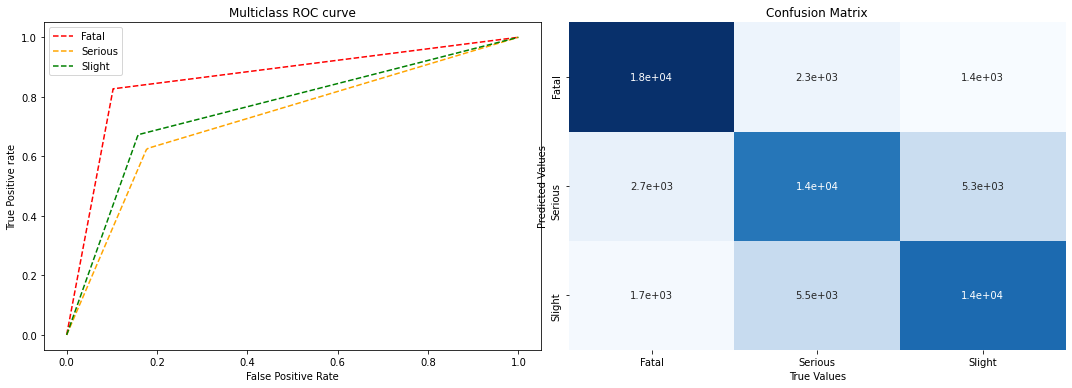

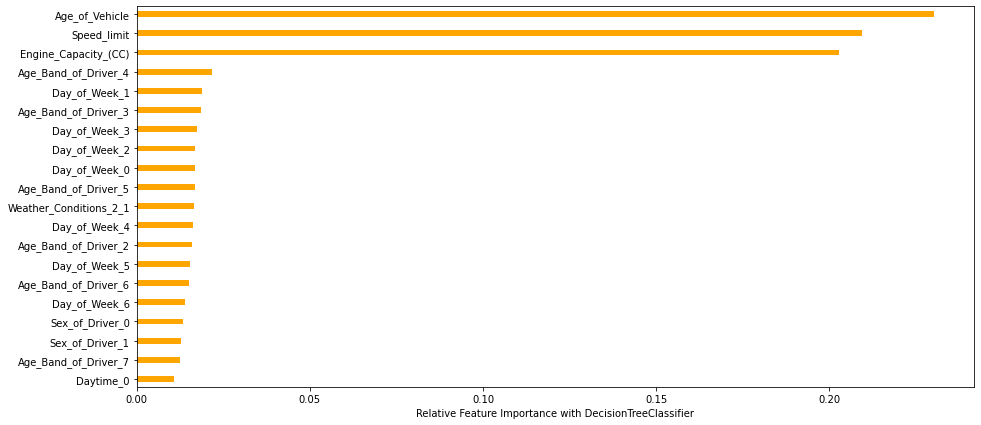

In [27]:
fit_pred_mod(2)

**RandomForestClassifier**

RandomForestClassifier
model score: 0.802
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     21678
           1       0.75      0.75      0.75     21536
           2       0.76      0.71      0.74     21514

    accuracy                           0.80     64728
   macro avg       0.80      0.80      0.80     64728
weighted avg       0.80      0.80      0.80     64728



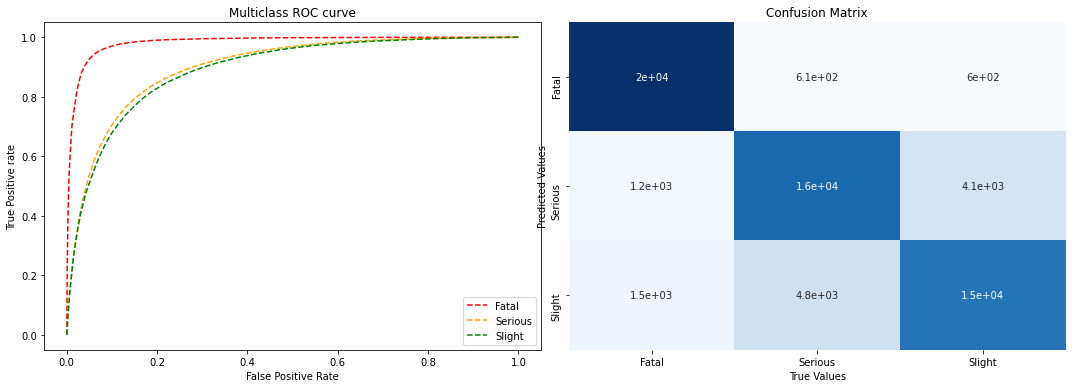

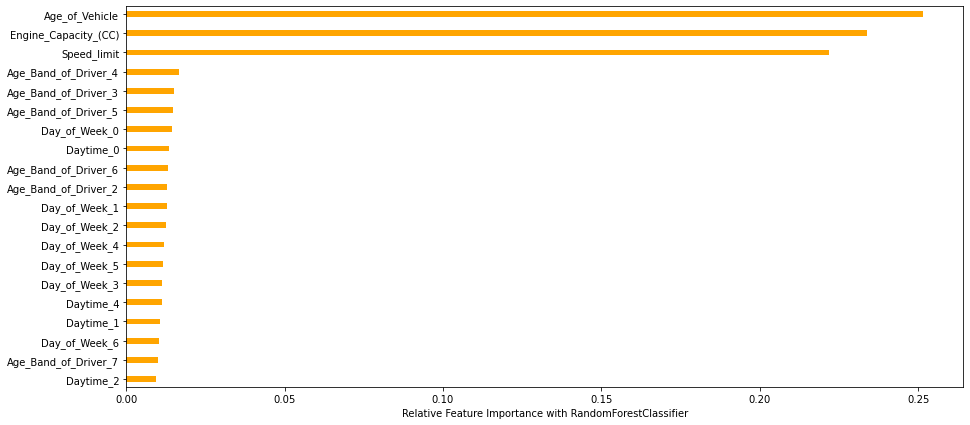

In [38]:
fit_pred_mod(3)

**BaggingClassifier**

BaggingClassifier
model score: 0.767
              precision    recall  f1-score   support

           0       0.82      0.91      0.86     21866
           1       0.70      0.68      0.69     21639
           2       0.76      0.71      0.73     21589

    accuracy                           0.77     65094
   macro avg       0.76      0.77      0.76     65094
weighted avg       0.76      0.77      0.76     65094



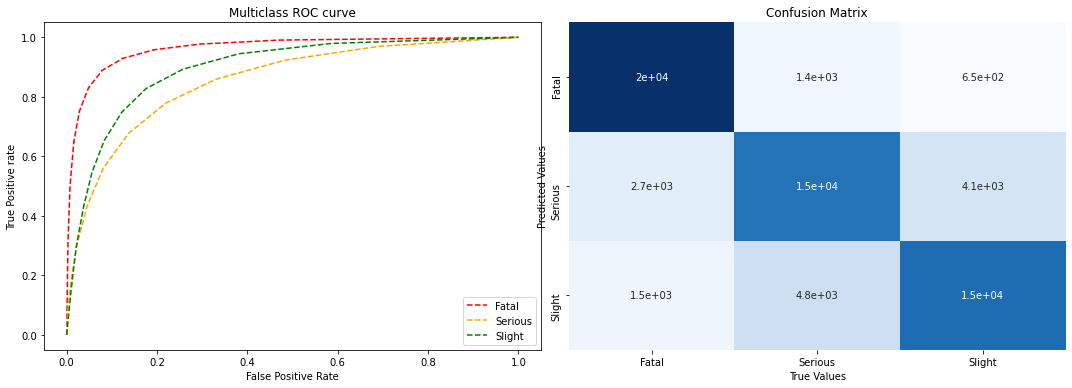

In [29]:
fit_pred_mod(4)

**KNeighborsClassifier**

KNeighborsClassifier
model score: 0.743
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     21866
           1       0.67      0.74      0.70     21639
           2       0.75      0.54      0.63     21589

    accuracy                           0.74     65094
   macro avg       0.74      0.74      0.73     65094
weighted avg       0.74      0.74      0.73     65094



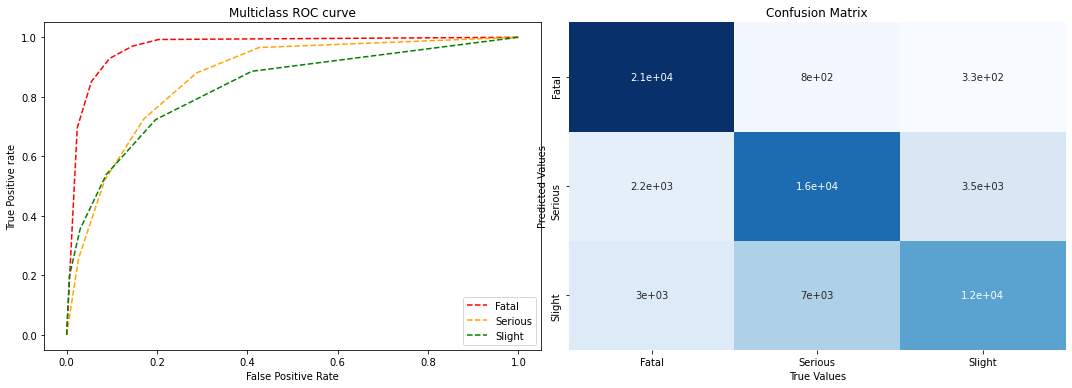

In [30]:
fit_pred_mod(6)

Como nuestra idea es centrarnos en los accidentes Fatales, seleccionaremos los modelos con más puntuación en la clase 0, es decir la clase Fatal.

Lo que queremos es un modelo que prediga si un accidente va a ser fatal, con una gran posibilidad de acierto.

En cuanto a la puntuación de los modelos.
- BaggingClassifier y RandomforestClassifier son los que mejor métricas han reportado en la clase 0.

- DecisionTreeClassifier y KNeighborsClassifier han reportados las peores areas bajo la curva ROC.

Una peculiaridad es que está prediciendo mejor los datos en la clase 0 cuando anteriormente en el dataset desbalanceado era la clase con menos registros, podría ser que tengamos aún alguna variable sesgada que hace que el modelo tenga más falsos negativos de los que debería.

En cuanto a las features, Age of vehicle es la indiscutible ganadora en importancia, seguido de Engine Capacity y speed limit.

Es claro que estas 3 variables juegan un papel muy importante en el entrenamiento del modelo.

**Precisión**

Métrica que utiliza  los falsos positivos para la evaluación, casos positivos que el modelo identifica como negativos.

No nos vale ya que si queremos predecir un accidente Fatal para tomar medidas en un punto crítico de la ciudad
nos va a dejar ubicaciones de accidentes fatales sin predecir y no queremos eso ya que el objetivo es detectar justamente estos puntos.

**Recall**

Métrica que utiliza los falsos negativos para la evaluacion, casos negativos que detecta como positivos.

Desde un punto de vista hipotético si tuvieramos que emplear dinero público para reforzar una ubicación de accidentes críticos, si el modelo no evalúa bien,
nos estaría prediciendo ubicaciones que no son fatales, aunque dentro de lo malo es preferible esta última métrica  ya que con un estudio posterior podríamos asegurarnos de la inversión en ese punto.

**F1_score**

Métrica utilizada en nuestro caso.

El valor F1 asume que nos importa de igual forma precisión y recall.

Se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones.

Podemos ver que el modelo con más puntuación en f1_score es Randomforestclassifier.


Una vez ya hemos generado los modelos anteriores con las respectivas puntuaciones, vamos a realizar una búsqueda de parámetros para cada uno de los modelos, intentado encontrar los mejores para una puntuación superior.

Para ello utilizaremos una pipeline con sklearn y gridsearchcv.

GridsearchCV iterará sobre todos los parámetros que le pasamos previamente y nos dará la mejor puntuación para el modelo correspondiente.

### *Iteración sobre parámetros con GridsearchCV*

#### *Definimos nuestra función con GridsearchCV*

Para ello es necesario crearnos un diccionario de parámetros para cada modelo con la finalidad de poder pasarlo a gridsearchcv.

Cuando acabe de hacer todas las iteraciones nos reportará el score y nos devolverá el modelo en cuestión en un .pkl en al carpeta gsearchcv.


In [41]:
def param_search(select_model,dump=None):
    
    #MODEL PARAMETERS
    #K-Nearest - Neighborg
    knn_grid = {
        'classifier__n_neighbors' : list(range(5,17,2))
        }
    #DecisionTreeclassifier
    tree_grid = {
    "classifier__min_samples_split" : list(range(2,8,2)),
    "classifier__criterion" : ['gini','entropy'] 
    }

    #Bagging Classifier
    bag_grid = {
     'classifier__n_estimators': [5, 10, 20 , 30 , 40]
    }
    #Random Forest
    rf_grid = {
        "classifier__n_estimators" : range(100,200,20),
        "classifier__criterion" : ["gini","entropy"]}
        
        
    if select_model == 1:
        models = DecisionTreeClassifier()
        name="DecisionTreeClassifier"
        grids = tree_grid
    elif select_model ==2:
        models = KNeighborsClassifier()
        name="KNeighborsClassifier"
        grids = knn_grid
    elif select_model == 3:
        models = BaggingClassifier()
        name = "BaggingClassifier"
        grids=bag_grid
    elif select_model == 4:
        name="RandomForestClassifier"
        models = RandomForestClassifier()
        grids=rf_grid
     
    
    numeric_features = num
    categorical_features = cat
    #Handling categorical and numerical data with Pipelines
    numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
    #('imputer', SimpleImputer(strategy='median')),
    #categorical_transformer = LabelEncoder()
    categorical_transformer = Pipeline(steps=[
    
    ('ohe', OneHotEncoder(handle_unknown='ignore'))])
    #('ohe', OneHotEncoder(handle_unknown='ignore'))])
    
    #categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    #categorical_transformer  = StandardScaler()
    preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),])

    random_seed = 12
    cv = 5
    
    #grids = [tree_grid,knn_grid,bag_grid,rf_grid]
    col = 0
    clf = Pipeline(steps=[('preprocessor', preprocessor)
                                  ,('classifier',models)])
    grid_search = GridSearchCV(clf, 
                          param_grid=grids,
                          cv=cv,scoring='f1_macro',
                          error_score=0,n_jobs=-1)

    grid_clf = grid_search.fit(X_train, y_train)
    print("{} f1_macro_score: {}".format(name,grid_search.best_score_))    
    print("{}: {}".format(name,grid_search.best_params_)) 
    with open("gsearchcv/gsearchcv_scores.txt", "a") as f:
        f.write('\nModel: {} \nBest_Score: {}\nBest_param: {}\n'.format(name ,grid_search.best_score_,grid_search.best_params_))
    print("Train score: ", grid_search.score(X_train,y_train))
    print("Test score: ", grid_search.score(X_test,y_test))
    
    if dump==1:
        joblib.dump(grid_search.best_estimator_, 'gscv/{}.pkl'.format(name))
        
    return

In [15]:
param_search(4,1)

RandomForestClassifier f1_macro_score: 0.8251609650418157
RandomForestClassifier: {'classifier__criterion': 'gini', 'classifier__n_estimators': 160}
Train score:  0.9960093650107967
Test score:  0.8348587144198746


In [16]:
param_search(3,1)

BaggingClassifier f1_macro_score: 0.8177818364726333
BaggingClassifier: {'classifier__n_estimators': 40}
Train score:  0.9956185617495957
Test score:  0.8326679484120457


In [17]:
param_search(1,1)

DecisionTreeClassifier f1_macro_score: 0.7513660264131821
DecisionTreeClassifier: {'classifier__criterion': 'gini', 'classifier__min_samples_split': 2}
Train score:  0.9960129026751278
Test score:  0.7687313676346382


In [17]:
param_search(2,1)

KNeighborsClassifier f1_macro_score: 0.7179505804072394
KNeighborsClassifier: {'classifier__n_neighbors': 5}
Train score:  0.8224316860899604
Test score:  0.7341361919541255


El mejor resultado ha sido RandomforestClassifier con un 0.82 en f1_macro_score seguido de BaggignClassifier con un 0.81.

No podemos asegurar que sea el mejor resultado ya que hay muchísimos más parámetros para probar y combinar, pero esto resultaría en un mayor número de iteraciones con un mayor tiempo de espera para cada modelo siendo así una limitación los 16vcpu de compute engine de google, por eso mismo me he centrado en los parámetros que a mi juicio son más representativos o tienen un mayor impacto en el modelo.

### *Curva de validación*

En Machine Learning, la validación del modelo se usa para medir la efectividad de un modelo ML.  Un buen modelo de aprendizaje automático no solo se ajusta muy bien a los datos de entrenamiento, sino que también se puede generalizar a nuevos datos de entrada.

La curva de validación es una técnica gráfica que se puede utilizar para medir la influencia de un solo hiperparámetro.  Al observar esta curva, puede determinar si el modelo está desajustado, sobreajustado o simplemente correcto para algún rango de valores de hiperparámetros.

El siguiente código muestra la Curva de validación con RandomforestClassifier para 4 parámetros:
-  max_depth
- n_estimators
- min_samples_split
- min_samples_leaf

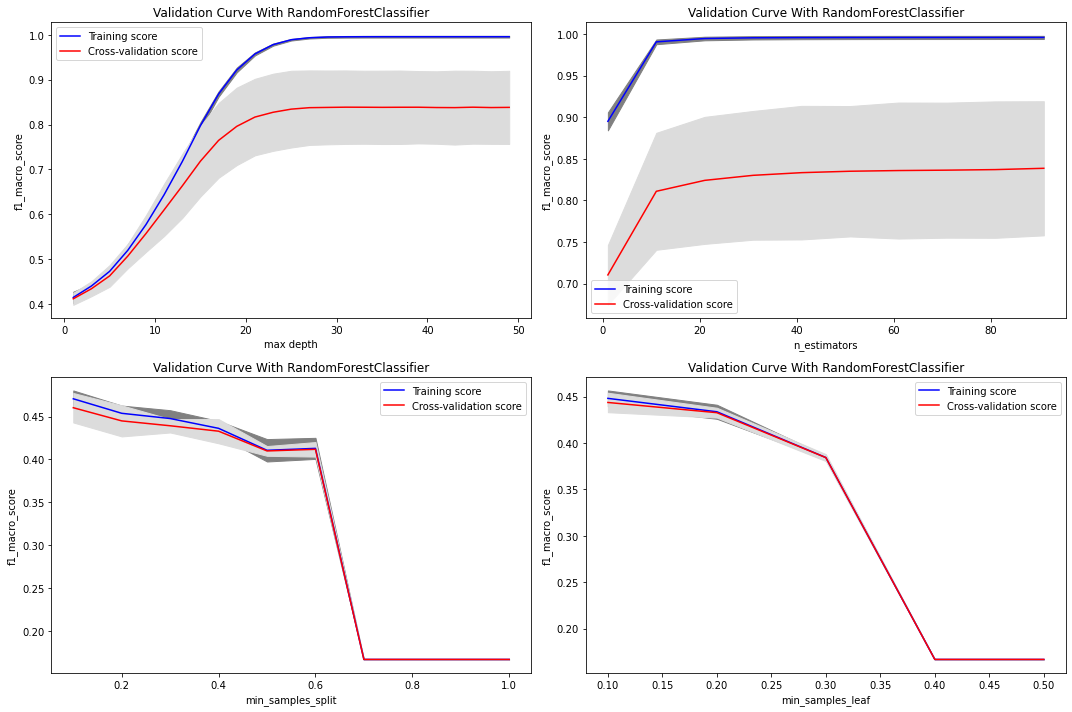

In [18]:
# Creating figure object
fig1,ax = plt.subplots(2,2,figsize=(15,10))
plt.subplot(221)
param_range = np.arange(1,50,2)

train_scores, test_scores = validation_curve(RandomForestClassifier(),X, y, param_name = 'max_depth', param_range=param_range,
                                      cv=5, scoring="f1_macro", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#fig = plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With RandomForestClassifier")
plt.xlabel("max depth")
plt.ylabel("f1_macro_score")
plt.tight_layout()
plt.legend(loc="best")


plt.subplot(222)

param_range = range(1,100,10)
train_scores, test_scores = validation_curve(RandomForestClassifier(),X, y, param_name = 'n_estimators' , param_range=param_range,
                                      cv=5, scoring="f1_macro", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#fig = plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With RandomForestClassifier")
plt.xlabel("n_estimators")
plt.ylabel("f1_macro_score")
plt.tight_layout()
plt.legend(loc="best")

    
plt.subplot(223)

param_range = np.linspace(0.1, 1.0, 10, endpoint=True)
train_scores, test_scores = validation_curve(RandomForestClassifier(),X, y, param_name = 'min_samples_split' , param_range=param_range,
                                      cv=5, scoring="f1_macro", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#fig = plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With RandomForestClassifier")
plt.xlabel("min_samples_split")
plt.ylabel("f1_macro_score")
plt.tight_layout()
plt.legend(loc="best")
#plt.show()

plt.subplot(224)

param_range = np.linspace(0.1, 0.5, 5, endpoint=True)
train_scores, test_scores = validation_curve(RandomForestClassifier(),X, y, param_name = 'min_samples_leaf' , param_range=param_range,
                                      cv=5, scoring="f1_macro", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

#fig = plt.subplots(1, figsize=(7,7))
plt.plot(param_range, train_mean, label="Training score", color="blue")
plt.plot(param_range, test_mean, label="Cross-validation score", color="red")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

plt.title("Validation Curve With RandomForestClassifier")
plt.xlabel("min_samples_leaf")
plt.ylabel("f1_macro_score")
plt.tight_layout()
plt.legend(loc="best")
#plt.show()

fig1.show()

Para el parámetro **max_depth** el gráfico muestra claramente que el aumento de la profundidad del árbol en las primeras etapas da como resultado una mejora correspondiente tanto en los
datos de entrenamiento como en los conjuntos de prueba.

Este comportamiento continúa hasta una profundidad de alrededor de 10 niveles, después de lo cual se muestra que el modelo se ajusta en exceso al conjunto de datos de entrenamiento a costa de un peor rendimiento en el conjunto de datos de reserva.


En cuanto al parámetro **n_estimators** nos reporta un peor escenario donde se puede apreciar mucho Overfitting desde el principio, ya que el conjunto de test y train nunca llegan a aproximarse, quedando 0.2 puntos entre una y otra.

Podemos observar que se produce Underfitting cuando se realiza una validación con los parámetros **min_samples_split** y **min_samples_leaf** para datos de test y train.

### *Métricas del modelo Randomforest con GridsearchCV*

In [88]:
clf = joblib.load("gsearchcv/RandomForestClassifier.pkl")

In [90]:
clf.score(X_train,y_train)

0.5273417525373828

In [92]:
y_hat = clf.predict(X_train)

In [93]:
print(classification_report(y_train,y_hat))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46     64455
           1       0.43      0.44      0.44     64568
           2       0.54      0.80      0.64     64582

    accuracy                           0.53    193605
   macro avg       0.55      0.53      0.51    193605
weighted avg       0.55      0.53      0.51    193605



In [94]:
y_hat = clf.predict(X_test)

In [96]:
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46     21592
           1       0.43      0.44      0.43     21479
           2       0.53      0.80      0.64     21465

    accuracy                           0.53     64536
   macro avg       0.55      0.53      0.51     64536
weighted avg       0.55      0.53      0.51     64536



In [97]:
y_hat = clf.predict(X)

In [98]:
print(classification_report(y,y_hat))

              precision    recall  f1-score   support

           0       0.69      0.35      0.46     86047
           1       0.43      0.44      0.44     86047
           2       0.54      0.80      0.64     86047

    accuracy                           0.53    258141
   macro avg       0.55      0.53      0.51    258141
weighted avg       0.55      0.53      0.51    258141



El modelo nos dá resultados mucho peores tanto en el modelo de train como en el modelo de test.

Es posible que al aumentar el parámetro n_estimators hayamos entrado en Underfitting, ya que si estuvieramos en Overfitting el conjunto de train nos tendría que dar una buena puntuación perdiendo solo en la de test.